In [7]:
# default_exp actorcritic.dads

In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [9]:
#export
import torch.nn.utils as nn_utils
from fastai.torch_basics import *
import torch.nn.functional as F
from fastai.data.all import *
from fastai.basics import *
from dataclasses import field,asdict
from typing import List,Any,Dict,Callable
from collections import deque
import gym
import torch.multiprocessing as mp
from torch.optim import *
from dataclasses import dataclass

from fastrl.data import *
from fastrl.async_data import *
from fastrl.basic_agents import *
from fastrl.learner import *
from fastrl.metrics import *
from fastai.callback.progress import *
from fastrl.ptan_extension import *
from fastrl.actorcritic.sac import *
from fastrl.actorcritic.diayn import *
import gym
from torch.distributions import *

import matplotlib.pyplot as plt

if IN_NOTEBOOK:
    from IPython import display
    import PIL.Image

In [10]:
# hide
import matplotlib.pyplot as plt

from nbdev.showdoc import *
from nbdev.imports import *
from nbdev.export2html import *
if not os.environ.get("IN_TEST", None):
    assert IN_NOTEBOOK
    assert not IN_COLAB
    assert IN_IPYTHON

# DADS

> Diversity Is All You Need

## GMM
> A neural net with a gaussian probability distribution component.

Gaussian Mixture Models parameterized by neural nets can be used for:
- Giving the probability that a given `state` + `action` will result in `next_state`
- Predict what the `next_state` will look like given a `state` + `action`

Hopefully from the list above, it is understandable *why* a GMM can be useful.
Since it has a probabilistic component, you can avoid instances of (easily) overfitting. 

In [11]:
# export 
class OptionalClampLinear(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False,
                 clip_min=0.3,clip_max=10.0):
        "Linear layer or constant block used for std."
        store_attr()
        if not self.fix_variance: self.fc=nn.Linear(self.num_inputs,self.state_dims)
    
    def forward(self,x):
        if self.fix_variance: return torch.full((x.shape[0],self.state_dims),1.0)
        else:                 return torch.clamp(nn.Softplus()(self.fc(x)),self.clip_min,self.clip_max)

class MultiCompGMM(Module):
    def __init__(self,num_inputs,state_dims,n_components,fix_variance:bool=False):
        "Multi-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.logit_fc=nn.Linear(self.num_inputs,self.n_components)
        self.mean_fcs=nn.ModuleList([nn.Linear(self.num_inputs,self.state_dims) 
                                     for _ in range(self.n_components)])
        self.std_fcs=nn.ModuleList([OptionalClampLinear(self.num_inputs,self.state_dims,fix_variance) 
                                    for _ in range(self.n_components)])
        self.means,self.logits,self.stds=[],[],[]
    
    def forward(self,x):
        self.means=torch.stack([o(x) for o in self.mean_fcs],dim=1)
        self.stds=torch.stack([o(x) for o in self.std_fcs],dim=1)
        self.logits=self.logit_fc(x)
        return MixtureSameFamily(
            mixture_distribution=Categorical(self.logits),
            component_distribution=Independent(Normal(self.means,self.stds),1)
        )
    
class SimpleGMM(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False):
        "Single-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.mean_fc=nn.Linear(self.num_inputs,self.state_dims)
        self.std_fc=OptionalClampLinear(self.num_inputs,self.state_dims,fix_variance)
        
    def forward(self,x): return Independent(Normal(self.mean_fc(x),self.std_fc(x)),1)

class GMM(Module):
    def __init__(self,num_inputs,state_dims,n_components,fix_variance:bool=False):
        "N-component GMM parameterized by fully connected layers with optional std layers."
        store_attr()
        if self.n_components>1: self.distribution=MultiCompGMM(num_inputs,state_dims,n_components,fix_variance)
        else:                   self.distribution=SimpleGMM(num_inputs,state_dims,fix_variance)
        
    def forward(self,x): return self.distribution(x)

The GMM is going to try to predict the next state. So lets make a simple input to optimize against.
This test will be of a hot airballoon. Lets see if we can have a reasonable next state prediction.

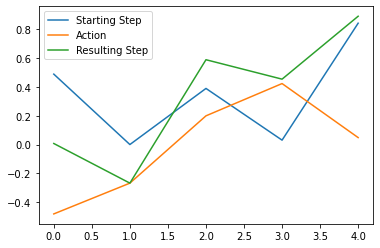

In [12]:
hot_air_ballon_start_states=torch.rand((5,1))
hot_air_ballon_start_actions=torch.rand((5,1))-0.5
hot_air_ballon_next_states=hot_air_ballon_start_states+hot_air_ballon_start_actions

plt.plot(hot_air_ballon_start_states.numpy(),label='Starting Step')
plt.plot(hot_air_ballon_start_actions.numpy(),label='Action')
plt.plot(hot_air_ballon_next_states.numpy(),label='Resulting Step')
plt.legend()
plt.show()

In [13]:
gmm=GMM(2,1,2,fix_variance=False)
opt=Adam(gmm.parameters(),lr=3e-4)

First, lets see if the GMM can predict the next state accurately...

In [14]:
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])
dist=gmm(x)
hot_air_ballon_start_states+dist.mean

tensor([[-0.4737],
        [ 2.3079],
        [ 2.1567],
        [ 0.3689],
        [-0.7923]], grad_fn=<AddBackward0>)

In [15]:
hot_air_ballon_next_states

tensor([[ 0.0073],
        [-0.2682],
        [ 0.5896],
        [ 0.4545],
        [ 0.8918]])

Yeah the GMM is way off...
So lets first see if we can get it to optimize to predict a next state...

In [16]:
next_timesteps=hot_air_ballon_next_states-hot_air_ballon_start_states    
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])

for step in range(5000):
    dist=gmm(x)

    opt.zero_grad()
    loss=-torch.mean(dist.log_prob(next_timesteps))
    loss.backward()
    if step%1000==0:print(loss,torch.mean(dist.log_prob(next_timesteps)))
    opt.step()

tensor(0.9393, grad_fn=<NegBackward>) tensor(-0.9393, grad_fn=<MeanBackward0>)
tensor(0.5572, grad_fn=<NegBackward>) tensor(-0.5572, grad_fn=<MeanBackward0>)
tensor(0.2285, grad_fn=<NegBackward>) tensor(-0.2285, grad_fn=<MeanBackward0>)
tensor(-0.0047, grad_fn=<NegBackward>) tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(-0.1535, grad_fn=<NegBackward>) tensor(0.1535, grad_fn=<MeanBackward0>)


In [17]:
x=torch.hstack([hot_air_ballon_start_states,hot_air_ballon_start_actions])
dist=gmm(x)
hot_air_ballon_start_states+dist.mean

tensor([[-0.0216],
        [ 0.5934],
        [ 1.2184],
        [ 0.5576],
        [ 0.8760]], grad_fn=<AddBackward0>)

In [18]:
hot_air_ballon_next_states

tensor([[ 0.0073],
        [-0.2682],
        [ 0.5896],
        [ 0.4545],
        [ 0.8918]])

This is much better, the GMM is making a better prediction of what the next state is going to be...

## Skill Dynamics
> Now that we have a working GMM, we need a way to modify our input data to be useful for the DADS agent.

In [19]:
# export
class SkillDynamics(Module):
    def __init__(self,s_dim,a_dim,n_components,fix_variance:bool=False,
                 use_model_mean:bool=None,use_batch_norm:bool=True,fc_params:tuple=None):
        store_attr(but='fc_params,use_model_mean')
        self.fc_params=ifnone(fc_params,(256,256))
        self.use_model_mean=ifnone(use_model_mean,n_components>1)
        if self.use_batch_norm:
            self.s_bn,self.sp_bn=nn.BatchNorm1d(s_dim),nn.BatchNorm1d(s_dim)
        self.fcs=nn.Sequential(*[nn.Linear((s_dim+a_dim) if i==0 else self.fc_params[i-1],p) 
                                for i,p in enumerate(self.fc_params)])
        
        self.gmm=GMM(self.fc_params[-1],s_dim,n_components,fix_variance)
        
    def forward(self,s,a,sp=None,training=True):
        "Returns the `GMM` distribution of `s` and `a`, mean, and **optionally** "\
        "log(p) of the state transition between `s` and `sp` if `sp` is not None."
        if sp is not None: sp=sp-s
        if not training: self.eval()
            
        if self.use_batch_norm:
            s=self.s_bn(s)
            if sp is not None: sp=self.sp_bn(sp)
            
        sa=torch.hstack([s,a])
        
        x=self.fcs(sa)
        
        dist=self.gmm(x)
        self.train()
        return dist,(sp if sp is None else dist.log_prob(sp))
    
    def log_prob(self,s,a,sp): return self(s,a,sp,training=False)[1]

    def predict_state(self,s,a):
        "Returns the predicted state that `s` and `a` will result in."
        dist,_=self(s,a,training=False)
        if self.use_model_mean:
            means,idx=dist.component_distribution.mean,torch.argmax(dist.mixture_distribution.logits,dim=1)
            pred_s=means[[torch.arange(means.shape[0]),idx]]
        else:
            pred_s=dist.mean
            
        if self.use_batch_norm:
            pred_s=pred_s*(self.sp_bn.running_var+1e-3).sqrt()+self.sp_bn.running_mean
        
        pred_s+=s
        return pred_s

The `SkillDynamics` module is actually pretty simple. It is tasked with getting the mean and log probability from the `GMM` and providing a convenient way to get a predicted state. It additionaly has the capability of batch normalization, noise, and input shuffling.

Going back to our hot air balloon example, lets feed the states, actions, and resulting states into it...

In [20]:
skill_dyn=SkillDynamics(1,1,2,fix_variance=False,use_batch_norm=False)
opt=Adam(skill_dyn.parameters(),lr=3e-4)

In [21]:
skill_dyn

SkillDynamics(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (gmm): GMM(
    (distribution): MultiCompGMM(
      (logit_fc): Linear(in_features=256, out_features=2, bias=True)
      (mean_fcs): ModuleList(
        (0): Linear(in_features=256, out_features=1, bias=True)
        (1): Linear(in_features=256, out_features=1, bias=True)
      )
      (std_fcs): ModuleList(
        (0): OptionalClampLinear(
          (fc): Linear(in_features=256, out_features=1, bias=True)
        )
        (1): OptionalClampLinear(
          (fc): Linear(in_features=256, out_features=1, bias=True)
        )
      )
    )
  )
)

Lets do a regular feed through and look at the output of our `SkillDynamics` instance.

In [22]:
skill_dyn(hot_air_ballon_start_states,hot_air_ballon_start_actions,
                           hot_air_ballon_next_states)

(MixtureSameFamily(
   Categorical(probs: torch.Size([5, 2]), logits: torch.Size([5, 2])),
   Independent(Normal(loc: torch.Size([5, 2, 1]), scale: torch.Size([5, 2, 1])), 1)),
 tensor([-0.4865, -0.4315, -0.4033, -0.5579, -0.3238],
        grad_fn=<LogsumexpBackward>))

We have 3 components: `dist`, `mean`, and `log_prob`.\
`dist` lets the user do more advanced operations with the results.\
`mean` will always return since at minimum `s` and `a` need to be passed in.\
`log_prob` can be returned if `sp` is not None.

The most immediately useful result is `log_prob` since it can be used for operations that need to know *what is the probability of this state occuring.*

However, like we said earlier, `dist` is returned because we might want to do more advanced operations. For example `predict_state`...

In [23]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 0.3138],
         [-0.0994],
         [ 0.3857],
         [ 0.0987],
         [ 0.7800]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 0.0073],
         [-0.2682],
         [ 0.5896],
         [ 0.4545],
         [ 0.8918]]))

This state prediction seems terrible! Obviously, we need to train `skill_dyn` so this is more accurate. You may notice the number of steps is 100 as opposed to 5000! This is because we are actually feeding a linear layer's output into the `GMM` as opposed to the `s+a` tensor directly. This is called a `latent space`, and these have friendlier values for the `GMM` to learn against. You will also see later that the results are a little more accurate also.

In [24]:
def train(steps=100,print_every=20):
    skill_dyn.train()
    for step in range(steps):
        _,log_prob=skill_dyn(hot_air_ballon_start_states,hot_air_ballon_start_actions,
                       hot_air_ballon_next_states)

        opt.zero_grad()
        loss=-torch.mean(log_prob)
        loss.backward()
        if step%print_every==0:print(loss,torch.mean(dist.log_prob(next_timesteps)))
        opt.step()
    skill_dyn.eval()
train()

tensor(0.4406, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2830, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2849, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2848, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2850, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)


In [25]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 0.0063],
         [-0.2689],
         [ 0.5901],
         [ 0.4555],
         [ 0.8922]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 0.0073],
         [-0.2682],
         [ 0.5896],
         [ 0.4545],
         [ 0.8918]]))

Much better! It is ok they are not exact, we want `SkillDynamics` to have a general idea on how current states and their actions can cause the state to change.

But here is a small wrench in the works. You will notice that the state spaces we are feeding into the model have values [-1, 1] which are nice and friendly to train our model on but also **highly unrealistic in the real world**. We will likely see values [-10,1000] possibly. Can we train on these? Let's convert our ballon problem into meters. We don't need to worry about actions because the values of actions are usually *within our control*.

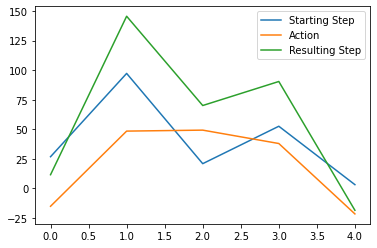

In [26]:
hot_air_ballon_start_states=torch.rand((5,1))*100
hot_air_ballon_start_actions=torch.rand((5,1))-0.5
hot_air_ballon_next_states=hot_air_ballon_start_states+hot_air_ballon_start_actions*100

plt.plot(hot_air_ballon_start_states.numpy(),label='Starting Step')
plt.plot(hot_air_ballon_start_actions.numpy()*100,label='Action')
plt.plot(hot_air_ballon_next_states.numpy(),label='Resulting Step')
plt.legend()
plt.show()

These are much bigger values... Training a model on these without normalzing can be very hard. 
The worst part is that in order to normalize something like states,
you would need to know *what is the absolute minimum and maximum this state will ever be*. This is a general problem in RL because when the agent is first
starting the states might start small, such as being newer the origin 0,0, but everntually as the agent gets better it starts to get to states like -20,100.
Our model needs to convert these into nice [0,1] or [-1,1] values.

So first, lets see if we can even learn anything without batch norm...

In [27]:
skill_dyn=SkillDynamics(1,1,2,fix_variance=False,use_batch_norm=False)
opt=Adam(skill_dyn.parameters(),lr=3e-4)
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[26.2782],
         [95.4494],
         [20.4711],
         [51.5636],
         [ 3.0872]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 11.4776],
         [145.6361],
         [ 70.0573],
         [ 90.4038],
         [-18.6300]]))

In [28]:
train(300,50)

tensor(166.3442, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(7.4911, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(7.1395, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(6.9110, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(6.7321, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(6.5922, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)


In [29]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 40.7076],
         [149.7475],
         [ 22.8561],
         [ 80.7531],
         [  4.2423]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 11.4776],
         [145.6361],
         [ 70.0573],
         [ 90.4038],
         [-18.6300]]))

Hm... It's diffinitely not amazing. The worst part is that this will likely be made worst with larger and differing batches. Lets see if using batch norm makes this better...

In [30]:
skill_dyn=SkillDynamics(1,1,2,fix_variance=False,use_batch_norm=True)
opt=Adam(skill_dyn.parameters(),lr=3e-4)
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 29.1465],
         [105.9709],
         [ 22.8306],
         [ 57.2867],
         [  3.4180]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 11.4776],
         [145.6361],
         [ 70.0573],
         [ 90.4038],
         [-18.6300]]))

In [31]:
train(300,50)

tensor(1.5101, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.0839, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2528, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2682, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2778, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)
tensor(-0.2825, grad_fn=<NegBackward>) tensor(0.2086, grad_fn=<MeanBackward0>)


In [32]:
'Prediction:',\
skill_dyn.predict_state(hot_air_ballon_start_states,hot_air_ballon_start_actions),\
'Actual',\
hot_air_ballon_next_states

('Prediction:',
 tensor([[ 11.2599],
         [148.0827],
         [ 70.1127],
         [ 91.3726],
         [-22.2219]], grad_fn=<AddBackward0>),
 'Actual',
 tensor([[ 11.4776],
         [145.6361],
         [ 70.0573],
         [ 90.4038],
         [-18.6300]]))

Great! It seems that batch norm makes `SkillDynamics` compatible with state space inputs of varying values 
that will addapt as the agent explores its environment.

In [98]:
SkillDynamics??

Init signature:
SkillDynamics(
    s_dim,
    a_dim,
    n_components,
    fix_variance: bool = False,
    use_model_mean: bool = None,
    use_batch_norm: bool = True,
    fc_params: tuple = None,
)
Docstring:      Same as `nn.Module`, but no need for subclasses to call `super().__init__`
Source:        
class PrePostInitMeta(FixSigMeta):
    "A metaclass that calls optional `__pre_init__` and `__post_init__` methods"
    def __call__(cls, *args, **kwargs):
        res = cls.__new__(cls)
        if type(res)==cls:
            if hasattr(res,'__pre_init__'): res.__pre_init__(*args,**kwargs)
            res.__init__(*args,**kwargs)
            if hasattr(res,'__post_init__'): res.__post_init__(*args,**kwargs)
        return res
File:           /opt/conda/envs/fastrl/lib/python3.7/site-packages/fastcore/meta.py
Type:           PrePostInitMeta
Subclasses:     


## DADS Agent

Some important notes...

Earlier `SkillDynamics` had:
```python
SkillDynamics(s_dim=1,a_dim=1,n_components=2)
```
where `a_dim` was the action dimension. In reality this is the **skill** dimension. You could say that if `a_dim` is being fed raw actions, then `SkillDynamics` should be renamed `ActionDynamics`.

However, you will see in `DADS`, that the `SkillDynamics` is always fed the skills as opposed to the primitive actions.

### Marginalization methods
> Ways of calculating the denominator.

A good reference is [Probability concepts explained: Marginalisation](https://towardsdatascience.com/probability-concepts-explained-marginalisation-2296846344fc). We need to calculate the intrinsic reward whose primary goal is to say:
- Did this skill produce predictable results? If so, let's reward it for doing so!

The actual math from the [Dynamics-Aware Unsupervised Discovery of Skills](https://arxiv.org/abs/1907.01657) for intrinsic reward:

<h5><center>
$r_z(s,a,s')=\log{\frac{q_{\phi}(s' \mid s,z)}{\sum_{i=1}^L q_{\phi}(s' \mid s,z_i)}}+\log{L},~~ z_i \sim p(z)$
</center></h5>

The first part of getting the intrinsic reward is getting the denominator:
$\sum_{i=1}^L q_{\phi}(s' \mid s,z_i)$ which is going to be the *all other possible skills*.

In [163]:
# export
def discrete_uniform(current_skill,latent_sz:int=2,alt_s:Tensor=None,deterministic:bool=False):
    "Returns a uniform discrete distribution."
    if deterministic: 
        return torch.cat([torch.roll(current_skill,i,dims=1) for i in range(1,alt_s.shape[0])])
    return Multinomial(1,probs=Tensor([1./latent_sz]*latent_sz)).sample_n(alt_s.shape[0])

In [164]:
skill_size=5 # Skill 
alt_s=torch.ones((5,3))
current_skill=Tensor([[0,0,0,1,0]])

We have the current skill that was used...

In [165]:
current_skill

tensor([[0., 0., 0., 1., 0.]])

...and so the other skills to compare it with are...

In [166]:
discrete_uniform(current_skill,latent_sz=skill_size,alt_s=alt_s,deterministic=True)

tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

... but this isn't very random is it? It just rolling them so let's add some random
alternative skills to look at...

In [167]:
discrete_uniform(current_skill,latent_sz=skill_size,alt_s=alt_s)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

But you may ask, what if the skill is continuous? For example:

In [168]:
current_skill=Tensor([[0.1,0.2,0.2,0.3,0.2]]);current_skill

tensor([[0.1000, 0.2000, 0.2000, 0.3000, 0.2000]])

Well then we have a few other disributions to sample instead!

In [ ]:
# hide
def show2d(t:Tensor):

In [173]:
# export
def cont_gaussian(sz:int,alt_s:Tensor):
    "Returns a continuous guassian distribution of size `sz`"
    return MultivariateNormal(torch.zeros(sz),torch.eye(sz)).sample_n(alt_s.shape[0])

In [180]:
cont_gaussian(skill_size,alt_s)

tensor([[-0.3195,  0.1748,  1.0341, -0.5630,  0.2380],
        [ 0.3240, -0.0412, -0.4597, -2.1902,  0.0244],
        [ 0.9082,  0.3915,  0.8459, -0.6514,  1.6217],
        [-1.7011, -1.1576, -0.1004, -0.8319,  0.3888],
        [-0.7661, -1.0383, -0.7232,  0.2897,  0.3999]])

In [177]:
np.random.uniform(
low=-1.0, high=1.0, size=(alt_s.shape[0], skill_size))

array([[-0.59757962, -0.00414586,  0.59792878, -0.93434294,  0.22219328],
       [ 0.07873538,  0.60221156, -0.90653623, -0.62373714,  0.09617011],
       [-0.68870973, -0.11055043, -0.48887387, -0.72144175,  0.81364112],
       [-0.88802999,  0.67341878,  0.32644702,  0.64245965,  0.16416884],
       [ 0.82191753,  0.98977457,  0.08325447,  0.36874363,  0.02606827]])

In [ ]:
# export
def 

### Agent

In [ ]:
# export
@delegates(SAC)
class DADS(SAC):
    def __init__(self,num_inputs,action_space,num_skills:int=20,include_actions:bool=False,hidden_size=100,lr=0.003,
                 n_components:int=4,prior_samples:int=100,latent_sz:int=2,**kwargs):
        store_attr()
        self.num_inputs=num_inputs+self.num_skills
        self.original_num_inputs=num_inputs
        self.skill_dyn=SkillDynamics(self.num_inputs,action_space.shape[0],self.n_components)
        super().__init__(self.num_inputs,self.latent_sz,hidden_size=hidden_size,lr=lr,**kwargs)
    
    def intrinsic_reward(self,s,z:int,sp):
        "Given a batch of `s` and `sp` what is the reward for using skill `z`?"
        n_repetitions=self.prior_samples if self.prior_samples>0 else self.latent_sz-1
        alt_s=torch.cat([s]*n_repetitions,axis=0)
        alt_sp=torch.cat([sp]*n_repetitions,axis=0)
        
        
        return 0

In [ ]:
cur_skill=[[0,0,0,1,0,0,0]]

In [ ]:
dads=DADS(1,gym.spaces.Box(-1,1,(1,)));dads

In [ ]:
dads.intrinsic_reward(hot_air_ballon_start_states,1,hot_air_ballon_next_states)



## Full Training

In [ ]:
# # export
# class Discriminator(Module):
#     "`Module` for storing skills. Receives input (`num_inputs`+`num_actions`) -> `num_skills`."
#     def __init__(self, num_inputs,num_actions,num_skills,hidden_dim):
#         self.linear1 = nn.Linear(num_inputs+num_skills, hidden_dim)
#         self.linear2 = nn.Linear(hidden_dim, hidden_dim)
#         self.linear3 = nn.Linear(hidden_dim,num_skills)

#         self.apply(weights_init_)

#     def forward(self, state):
#         x = F.relu(self.linear1(state.float()))
#         x = F.relu(self.linear2(x))
#         return self.linear3(x)

In [ ]:
# # export
# @delegates(SAC)
# class DADS(SAC):
#     def __init__(self,num_inputs,action_space,discriminator:Module=None,num_skills:int=20,
#                  find_best_skill_interval:int=10,scale_entropy:float=1,
#                  best_skill_n_rollouts:int=10,include_actions:bool=False,
#                  learn_p_z:bool=False,add_p_z:bool=True,hidden_size=100,lr=0.003,**kwargs):
#         store_attr()
#         self.num_inputs=num_inputs+self.num_skills
#         self.original_num_inputs=num_inputs
#         self.p_z=np.full(self.num_skills,1.0/self.num_skills)
#         self.discriminator=Discriminator(self.original_num_inputs,action_space.shape[0],
#                                          num_skills,hidden_size)

#         self.discriminator_optim = Adam(self.discriminator.parameters(), lr=self.lr)

#         self.log_p_z_episode=[]
#         self.z=0
#         self.reset_z()


#         super().__init__(self.num_inputs,action_space,hidden_size=hidden_size,lr=lr,**kwargs)

#     def sample_z(self):
#         """Samples z from p(z), using probabilities in self._p_z."""
#         return np.random.choice(self.num_skills,p=self.p_z)

#     def reset_z(self): self.z=self.sample_z()
#     def __call__(self,s,asl):
#         aug_s=self.concat_obs_z(s,self.z)
#         return super().__call__(aug_s,asl)

#     def concat_obs_z(self,obs,z):
#         """Concatenates the observation to a one-hot encoding of Z."""
#         assert np.isscalar(z)
#         if type(obs)==list and len(obs)==1: obs=obs[0]
#         if len(obs.shape)==2 and obs.shape[0]==1: obs=obs[0]

#         z_one_hot=np.zeros(self.num_skills)
#         z_one_hot[z]=1
#         if type(obs)==Tensor: obs=obs.cpu()
#         return torch.FloatTensor(np.hstack([obs,z_one_hot])).reshape(1,-1)

#     def skill_p(self,skill,next_state):
#         unnorm_skill_dist=self.discriminator(next_state).unsqueeze(0)
#         skill_p=F.softmax(unnorm_skill_dist)[:,skill]
#         return skill_p,unnorm_skill_dist

#     def discriminator_learn(self,skill,out):
#         self.discriminator_optim.zero_grad()
#         loss=nn.CrossEntropyLoss()(out,torch.LongTensor([skill]))
#         loss.backward()
#         self.discriminator_optim.step()

#     def intrinsic_reward(self,next_state):
#         skill_p,disc_out=self.skill_p(self.z,next_state)
#         intrinsic_reward=np.log(skill_p.cpu().detach()+1e-8)-np.log(self.p_z[self.z])
# #         print(skill_p,self.p_z,intrinsic_reward)
#         return intrinsic_reward,disc_out


In [ ]:
# # export
# class DiscriminatorTrainer(ExperienceReplay):

#     def __init__(self,*args,**kwargs):
#         self.log_p_z_episode=[]
#         super().__init__(*args,**kwargs)
        
#     def before_fit(self):
#         self.learn.agent.warming_up=True
#         while len(self.queue)<self.starting_els:
#             for i,o in enumerate(self.dls.train):
#                 z=self.learn.agent.z
#                 batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(o[0][i],z)[0],
#                                            action=o[1][i],
#                                            reward=o[2][i],
#                                            last_state=self.learn.agent.concat_obs_z(o[3][i],z)[0], 
#                                            done=(o[4][i] and self.max_steps!=o[6][i]),
#                                            episode_reward=o[5][i],steps=o[6][i])
#                                     for i in range(len(o[0]))]
# #                 print(self.max_steps,max([o.steps for o in batch]))
# #                 print(batch[0])
#                 for k in range(len(batch)):
#                     intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
#                     self.learn.agent.discriminator_learn(self.agent.z,disc_out)
#                     batch[k]=ExperienceFirstLast(
#                         state=batch[k].state.to(device=default_device()),
#                         action=batch[k].action,
#                         reward=intrinsic_reward,
#                         last_state=batch[k].last_state.to(device=default_device()),
#                         done=batch[k].done,
#                         episode_reward=batch[k].episode_reward,
#                         steps=batch[k].steps
#                     )


# #                 print(batch[0])
#                 for _b in batch:self.queue.append(_b)
#                 if any([_b.done for _b in batch]): self.learn.agent.reset_z()
#                 if len(self.queue)>self.starting_els:break
#         self.learn.agent.warming_up=False

# # #     def after_epoch(self):
# # #         print(len(self.queue))
#     def before_batch(self):
# #         print(len(self.queue))
#         b=list(self.learn.xb)+list(self.learn.yb)
#         z=self.learn.agent.z
#         batch=[ExperienceFirstLast(state=self.learn.agent.concat_obs_z(b[0][i],z)[0],
#                                    action=b[1][i],
#                                    reward=b[2][i],
#                                    last_state=self.learn.agent.concat_obs_z(b[3][i],z)[0], 
#                                    done=(b[4][i] and self.max_steps!=b[6][i]),
#                                    episode_reward=b[5][i],steps=b[6][i])
#               for i in range(len(b[0]))]
        
#         for k in range(len(batch)):
#             intrinsic_reward,disc_out=self.learn.agent.intrinsic_reward(Tensor(batch[k].last_state))
#             self.learn.agent.discriminator_learn(self.agent.z,disc_out)
#             batch[k]=ExperienceFirstLast(
#                 state=batch[k].state.to(device=default_device()),
#                 action=batch[k].action,
#                 reward=intrinsic_reward,
#                 last_state=batch[k].last_state.to(device=default_device()),
#                 done=batch[k].done,
#                 episode_reward=batch[k].episode_reward,
#                 steps=batch[k].steps
#             )
        
# #         print(self.learn.xb)
#         self.learn.xb=(torch.stack([e.state for e in batch]),)
# #         print(self.learn.yb)
#         self.learn.yb=(torch.stack([o.action for o in batch]),
#                        torch.stack([o.reward for o in batch]),
#                        torch.stack([o.last_state for o in batch]),
#                        torch.stack([o.done for o in batch]),
#                        torch.stack([o.episode_reward for o in batch]),
#                        torch.stack([o.steps for o in batch]))
# #         print(self.learn.yb)
        
#         for _b in batch: self.queue.append(_b)
#         idxs=np.random.randint(0,len(self.queue), self.bs)
#         self.learn.sample_yb=[self.queue[i] for i in idxs]

In [ ]:
# from pybulletgym.envs import *

# env='InvertedPendulumPyBulletEnv-v0'
# agent=DADS(5,gym.make(env).action_space,gamma=0.99,tau=0.005,alpha=0.1,hidden_size=300,num_skills=5)
# block=FirstLastExperienceBlock(agent=agent,seed=0,n_steps=2,exclude_nones=True,
#                                dls_kwargs={'bs':1,'num_workers':0,'verbose':False,'indexed':True,'shuffle_train':False})
# blk=IterableDataBlock(blocks=(block),splitter=FuncSplitter(lambda x:False))
# dls=blk.dataloaders([env]*1,n=10,device=default_device())

# learner=SACLearner(dls,agent=agent,cbs=[DiscriminatorTrainer(sz=1000000,bs=64,starting_els=1000,max_steps=gym.make(env)._max_episode_steps),
#                                         SACCriticTrainer],
#                    metrics=[AvgEpisodeRewardMetric(experience_cls=ExperienceFirstLast)])
# learner.fit(1,lr=0.003,wd=0)

In [ ]:
# # hide
# # slow
# import gym
# from IPython import display
# import PIL.Image
# %matplotlib inline

# # env=gym.make('InvertedPendulumPyBulletEnv-v0')
# # s=env.reset()

# # for z in range(5):
# #     for i in range(0,100,20):
# #         s=env.reset()
# #         env.seed(i)
# #         for _ in range(200):
# #             display.clear_output(wait=True)
# #             display.display(PIL.Image.fromarray(env.render(mode='rgb_array')))

# #             agent.z=z
# #             a,_=agent(s,None)

# #             s,r,d,_=env.step(a)
# #             if d:
# #                 break

In [ ]:
# hide
from nbdev.export import *
from nbdev.export2html import *
notebook2script()
notebook2html()